# Real estate ROI calculator 

## Configurables
Change your url and location here

In [3]:
import datetime

#Replace this url with the url of your search results
#url = 'https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-kaufen?enteredFrom=one_step_search'
# state/city
# location = "berlin/berlin"
# location = "baden-wuerttemberg/pforzheim"
# location = "niedersachsen/lueneburg-kreis"
location = "bayern/fuerth-kreis"

# location = "sachsen-anhalt/magdeburg"
propertyType = 'wohnung'
# url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/rheinland-pfalz/alzey-worms-kreis/wohnung-kaufen?enteredFrom=result_list'
url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/' + location + '/'+propertyType+'-kaufen?enteredFrom=result_list'

actualDate = datetime.date.today()
actualDate = actualDate.strftime('%Y-%m-%d')
city = location.split('/')[1]
file_name_csv_raw = 'immobilienscout_result_' + city + '_' + actualDate + '.csv'
file_folder = 'data'
file_path = file_folder + '/' +  file_name_csv_raw

# Your variables to change
rent_price_index = 9
equity_percentage = 0.20
interest_rate = 0.01
mortgage_payment_rate = 0.02

# Standard percentages
notary_percentage = 0.015
transfer_tax_percentage = 0.05
land_registry_tax_percentage = 0.005
additional_costs_rate_per_m2 = 0.9 

## Setup

In [4]:
import urllib.request
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Selector
import selenium
from selenium import webdriver
import chromedriver_binary
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

import json
import re
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:

columns = ['id_expose', 'url', 'title', 'address', 'contact_person', 'telephone', 'mobile', 'fax', 'price_purchase', 'estimated_monthly_rate', 'rooms', 'living_area_m2', 'furnishing', 'flat_type', 'floor', 'floor_total', 'bedrooms', 'commission_buyer_rate', 'maintenance_cost', 'construction_year', 'object_state', 'heating_type', 'energy_efficiency_class', 'location']

df_base = pd.DataFrame(columns = columns)

options = Options()
options.headless = True

crawler_name = 'scrapper_immobilienscout'

base_uri = 'immobilienscout24.de'
base_url = 'https://www.immobilienscout24.de'

In [6]:
driver = webdriver.Chrome()
# OLD configuration
#driver = webdriver.Chrome(options=options, executable_path="chromedriver.exe")

class Scrap_immobilienscout(scrapy.Spider):
    
    name = crawler_name
    
    def start_requests(self):
        first_page = urllib.request.urlopen(url_to_crawl)
        max_pages = first_page.read()
        max_pages = max_pages.decode("utf8")
        first_page.close()

        max_pages_selector = Selector(text = max_pages)
        max_pages = max_pages_selector.xpath('//select[@aria-label="Seitenauswahl"]/option[last()]/@value').extract_first()
        max_pages = int(max_pages) if max_pages is not None else 1
        
        base_url = url_to_crawl.replace('enteredFrom=one_step_search', '')
        
        for page_number in range(max_pages):
            url = base_url + 'pagenumber=' + str(page_number + 1)
            yield scrapy.Request(url, callback = self.parse_properties_list)
    
    def parse_properties_list(self, response):
        
        property_urls = response.xpath('//a[contains(@class, "result-list-entry__brand-title-container")]/@href').extract()
        
        for url in property_urls:
            if base_uri not in url:
                url = base_url + url + '#/'
                driver.get(url)
                src = driver.page_source
                self.scrap_property(src, url)
    
    # TODO rename variables
    # TODO clarify default values
    # TODO fix parse issues (int, roundings, etc.)
    def scrap_property(self, src, url):
        sel = Selector(text = src)

        id_expose = '' # TODO get expose substring of url
        
        title = sel.css('h1#expose-title ::text').extract_first()
        
        address = sel.xpath('//div[@class="address-block"]//span[@class="block font-nowrap print-hide"]//text()').extract_first()
        address = address.strip() if address is not None else ''

        region = sel.css('span.zip-region-and-country::text').extract_first()
        address += ' ' + region if region is not None else ''
        
        contact_person = sel.xpath('//div[@data-qa="contactName"]//text()').extract_first()
        contact_person = contact_person if contact_person is not None else ''
        
        phone = sel.xpath('//script//text()').extract_first()
        phone = phone if phone is not None else ''

        telefon = re.findall('"phoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        telefon = telefon[0].replace(' ', '') if len(telefon) > 0 else None
        
        mobil = re.findall('"cellPhoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        mobil = mobil[0] if len(mobil) > 0 else ''
        mobil = mobil.replace(' ', '')

        fax = re.findall('"faxNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        fax = fax[0] if len(fax) > 0 else ''
        fax = fax.replace(' ', '')
        
        price = sel.xpath('//dd[contains(@class, "is24qa-kaufpreis")]//text()').extract_first()
        price = re.sub('[^0-9]', '', price) if price is not None else 0
        price = int(price)
        
        estimated_monthly_rate = sel.xpath('//span[contains(@class, "monthly-rate-result") and contains(@class, "monthly-rate-value")]//text()').extract_first()
        estimated_monthly_rate = re.sub('[^0-9]', '', estimated_monthly_rate) if estimated_monthly_rate is not None else 0
        estimated_monthly_rate = int(estimated_monthly_rate)
        
        rooms_count = sel.xpath('//dd[contains(@class,"is24qa-zimmer")]/text()').extract_first()
        rooms_count = float(rooms_count.replace(" ","").replace(",",".") ) if rooms_count is not None else 0
        
        living_area = sel.xpath('//dd[contains(@class, "is24qa-wohnflaeche-ca")]/text()').extract_first()
        living_area = re.sub('[^0-9\.]', '', living_area.replace(",",".")) if living_area is not None else 0
        living_area = float(living_area)
        
        furnishing = sel.xpath('//div[contains(@class, "criteriagroup") and contains(@class, "boolean-listing")]//span[contains(@class, "palm-hide")]/text()').extract()
        furnishing = list(set(furnishing))
        furnishing = [t for t in furnishing if t != ' ']
        furnishing = furnishing if len(furnishing) > 0 else ''
        
        flat_type = sel.xpath('//dd[contains(@class, "is24qa-typ")]/text()').extract_first()
        
        floor = sel.xpath('//dd[contains(@class, "is24qa-etage")]//text()').extract_first()
        floor = floor if floor is not None else ''
        floor = re.findall('[0-9]+', floor)
        total_floors = int(floor[1]) if len(floor) > 1 else 0
        floor = int(floor[0]) if len(floor) > 0 else 0
        
        bedroom = sel.xpath('//dd[contains(@class, "is24qa-schlafzimmer")]//text()').extract_first()
        bedroom = re.sub('[^0-9]', '', bedroom) if bedroom is not None else 0
        bedroom = int(bedroom)
        
        allowance = sel.xpath('//dd[contains(@class, "is24qa-hausgeld")]//text()').extract_first()
        allowance = re.sub('[^0-9]', '', allowance) if allowance is not None else 0
        allowance = int(allowance)
        
        commission = sel.xpath('//dd[contains(@class, "is24qa-provision")]/text()').extract_first()
        
        if commission is not None:
            try:
                commission = re.search('[0-9]+,?[0-9]*', commission).group() 
            except:
                commission = ''
        else:
            commission = ''

        commission = commission.replace(',', '.')
        commission = float(commission) if len(commission) > 0 else 0
        
        construction_year = sel.xpath('//dd[contains(@class, "is24qa-baujahr")]//text()').extract_first()
        
        object_state = sel.xpath('//dd[contains(@class, "is24qa-objektzustand")]//text()').extract_first()
        
        heatingy_type = sel.xpath('//dd[contains(@class, "is24qa-heizungsart")]//text()').extract_first()
        
        energy_efficiency_class = sel.xpath('//dd[contains(@class, "is24qa-energieeffizienzklasse")]//text()').extract_first()
        energy_efficiency_class = energy_efficiency_class if energy_efficiency_class is not None else ''
        
        location = sel.xpath('//pre[contains(@class, "is24qa-lage")]/text()').extract_first()

        lst_row = [id_expose, url, title, address, contact_person, telefon, mobil, fax, price, estimated_monthly_rate, rooms_count, living_area, furnishing, flat_type, floor, total_floors, bedroom, commission, allowance, construction_year, object_state, heatingy_type, energy_efficiency_class, location]
        df_base.loc[len(df_base)] = lst_row
        df_base.to_csv(file_path, index=False)
        
process = CrawlerProcess()
process.crawl(Scrap_immobilienscout)
process.start()
# TODO unblock process. See: https://docs.scrapy.org/en/latest/topics/practices.html 

88#/"}
2020-07-20 23:09:53 [urllib3.connectionpool] DEBUG: http://127.0.0.1:54976 "POST /session/490acdff6af1cbb5b8c49f2742c77826/url HTTP/1.1" 200 14
2020-07-20 23:09:53 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-20 23:09:53 [selenium.webdriver.remote.remote_connection] DEBUG: GET http://127.0.0.1:54976/session/490acdff6af1cbb5b8c49f2742c77826/source {}
2020-07-20 23:09:53 [urllib3.connectionpool] DEBUG: http://127.0.0.1:54976 "GET /session/490acdff6af1cbb5b8c49f2742c77826/source HTTP/1.1" 200 880018
2020-07-20 23:09:53 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-20 23:09:54 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:54976/session/490acdff6af1cbb5b8c49f2742c77826/url {"url": "https://www.immobilienscout24.de/expose/119807872#/"}
2020-07-20 23:09:54 [urllib3.connectionpool] DEBUG: http://127.0.0.1:54976 "POST /session/490acdff6af1cbb5b8c49f2742c77826/url HTTP/1.1" 200 14
2020-07-20 23:0

In [7]:
# Write (parse) to CSV again
df_base.to_csv(file_path, index=False)

In [8]:
# Read CSV again
df_base = pd.read_csv(file_path)

## Exploration

In [9]:
# dataframe dimensions
df_base.shape

(48, 24)

In [10]:
# column datatypes
df_base.dtypes

id_expose                  float64
url                         object
title                       object
address                     object
contact_person              object
telephone                  float64
mobile                     float64
fax                        float64
price_purchase               int64
estimated_monthly_rate       int64
rooms                      float64
living_area_m2             float64
furnishing                  object
flat_type                   object
floor                        int64
floor_total                  int64
bedrooms                     int64
commission_buyer_rate      float64
maintenance_cost             int64
construction_year          float64
object_state                object
heating_type                object
energy_efficiency_class     object
location                    object
dtype: object

In [11]:
df_base.select_dtypes(include=['object']).isnull().sum()

url                         0
title                       0
address                     0
contact_person              0
furnishing                  0
flat_type                   9
object_state                9
heating_type                6
energy_efficiency_class    27
location                    0
dtype: int64

In [12]:
df_base.head(10)
#df_base['url'][4]
#df[0:5]
#df.tail()

,id_expose,url,title,address,contact_person,telephone,mobile,fax,price_purchase,estimated_monthly_rate,rooms,living_area_m2,furnishing,flat_type,floor,floor_total,bedrooms,commission_buyer_rate,maintenance_cost,construction_year,object_state,heating_type,energy_efficiency_class,location
0,NaN,https://www.immobilienscout24.de/expose/118787687#/,Maisonettewohnung mit eigenem Home Office Bereich,"Raindorfer Weg 8, 90579 Langenzenn, Fürth (Kreis)",Herr Horst Mayr,9.119270e+10,1.520904e+10,9.116501e+10,449950,0,4.0,116.87,"['Provisionsfrei', 'Gäste-WC', 'Keller', 'Balkon/ Terrasse']",Maisonette,3,3,3,0.00,0,2019.0,Erstbezug,NaN,A+,"Leben in Zentraler Lage\nIn Langenzenn treffen sich Tradition und Moderne: Die Kleinstadt mit über 10.600 Einwohnern ist geprägt vom pittoresken Ortskern, historischen Bauten und einer gotischen K..."
1,NaN,https://www.immobilienscout24.de/expose/113834643#/,Traumlage am Fuße der Alten Veste,"Fürther Straße 57, 90513 Zirndorf, Fürth (Kreis)",Herr Matthias Kluger,9.119343e+10,NaN,NaN,494029,0,4.0,109.22,"['Keller', 'Einbauküche', 'Provisionsfrei', 'Personenaufzug', 'Balkon/ Terrasse', 'Stufenloser Zugang', 'Gäste-WC']",Etagenwohnung,1,2,3,0.00,0,2020.0,Erstbezug,Gas-Heizung,NaN,"Städter sein und trotzdem wissen, wie sich Natur anfühlt. Diesen Spagat schaffen nicht viele Orte. Das Wohnensemble in der Fürther Straße in Zirndorf erfüllt genau diese beiden Sehnsüchte.\nUnterh..."
2,NaN,https://www.immobilienscout24.de/expose/119115022#/,Wohntraum am Fuße der Alten Veste KfW 55,"Fürther Straße 57, 90513 Zirndorf, Fürth (Kreis)",Herr Matthias Kluger,9.119343e+10,NaN,NaN,414558,0,3.0,87.14,"['Keller', 'Einbauküche', 'Provisionsfrei', 'Personenaufzug', 'Balkon/ Terrasse', 'Garten/ -mitbenutzung', 'Stufenloser Zugang', 'Gäste-WC']",Erdgeschosswohnung,0,2,2,0.00,0,2021.0,Erstbezug,Gas-Heizung,A+,"Städter sein und trotzdem wissen, wie sich Natur anfühlt. Diesen Spagat schaffen nicht viele Orte. Das Wohnensemble in der Fürther Straße in Zirndorf erfüllt genau diese beiden Sehnsüchte.\nUnterh..."
3,NaN,https://www.immobilienscout24.de/expose/120225624#/,HEGERICH: Nichts von der Stange - Außergewöhnliches Reiheneckhaus,"90513 Zirndorf, Fürth (Kreis)",Marcus Schubert,NaN,NaN,9.111316e+10,475000,0,4.0,120.00,"['Gäste-WC', 'Einbauküche']",NaN,0,0,0,4.64,0,2013.0,Neuwertig,NaN,A,"Der Luxus des Hauses wird nur noch vom Luxus seiner Lage übertroffen. Sie finden sich hier in einer sehr ruhigen, entspannten und offenen Nachbarschaft wieder, in der Sie trotzdem eine gigantische..."
4,NaN,https://www.immobilienscout24.de/expose/119676838#/,* Ihre neue Loftfläche mit Terrasse *,"90513 Zirndorf, Fürth (Kreis)",Dominik Höger,9.116894e+10,NaN,NaN,335000,0,4.0,132.00,['Keller'],NaN,0,0,0,4.00,0,1928.0,NaN,Zentralheizung,NaN,Dieses einzigartige Objekt befindet sich in zentraler Lage in Zirndorf. Die historische Altstadt ist nur ein paar Schritte entfernt. Alle Einkaufsmöglichkeiten und Schulsysteme sind fußläufig erre...
5,NaN,https://www.immobilienscout24.de/expose/120322850#/,"KILIAN IMMOBILIEN! 3,5 ZI. ETW IM 4. OG MIT 83 M² IN STEIN BEI NBG! BALKON * AUFZUG * TAGESLICHTBAD","90547 Stein, Fürth (Kreis)",Herr Dipl. BW (FH) Thomas Kilian,9.171896e+09,1.707363e+09,NaN,239000,0,3.5,83.00,"['Einbauküche', 'Garten/ -mitbenutzung', 'Keller', 'Balkon/ Terrasse']",Etagenwohnung,4,8,2,4.99,291,1972.0,Modernisiert,Zentralheizung,C,"Diese 3,5 Zimmer Wohnung im 4. Obergeschoss mit 83 qm Wohnfläche, mit Personenaufzug und mit Südbalkon befindet sich im beliebten Stein bei Nürnberg.\n\nHier in dieser Lage von Stein und in dieser..."
6,NaN,https://www.immobilienscout24.de/expose/118517231#/,Galeriewohnung mit Balkon: Blick über Ammerndorf inklusive,"90614 Ammerndorf, Fürth (Kreis)",Frau Nevena Wirth,9.122888e+10,1.609028e+10,9.122888e+10,369000,0,4.0,130.00,"['Einbauküche', 'Balkon/ Terrasse']",Maisonette,1,0,1,4.64,0,1998.0,Gepflegt,Gas-Heizung,C,"Ammerndorf ist ein Markt im mittelfränkischen Landkreis Fürth. Mitten im Grünen gelegen, und dennoch

In [13]:
# TODO transform into numerical values for historgrams
# df_base.hist(xrot=-45, figsize=(14,14))

In [14]:
df_base.describe()

,id_expose,telephone,mobile,fax,price_purchase,estimated_monthly_rate,rooms,living_area_m2,floor,floor_total,bedrooms,commission_buyer_rate,maintenance_cost,construction_year
count,0.0,4.200000e+01,3.000000e+01,2.100000e+01,48.000000,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,45.000000
mean,NaN,7.302684e+10,9.876467e+09,7.830078e+10,393083.562500,0.0,3.312500,102.296250,1.187500,1.500000,1.437500,2.276875,45.625000,1995.533333
std,NaN,3.526315e+10,6.768331e+09,3.237417e+10,122974.687842,0.0,0.711793,24.875354,1.299038,2.231305,1.070022,2.313571,100.321531,31.563500
min,NaN,9.117574e+08,1.707363e+09,9.117716e+08,179000.000000,0.0,2.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1928.000000
25%,NaN,9.114304e+10,1.728109e+09,9.111316e+10,326750.000000,0.0,3.000000,86.105000,0.000000,0.000000,0.750000,0.000000,0.000000,1972.000000
50%,NaN,9.119306e+10,1.512245e+10,9.122887e+10,389400.000000,0.0,3.250000,101.790000,1.000000,0.000000,1.500000,2.000000,0.000000,2013.000000
75%,NaN,9.122887e+10,1.516514e+10,9.122887e+10,456037.500000,0.0,4.000000,120.000000,2.000000,2.250000,2.000000,4.640000,0.000000,2019.000000
max,NaN,9.122888e+10,1.609028e+10,9.122888e+10,732400.000000,0.0,4.000000,151.000000,4.000000,8.000000,3.000000,4.990000,291.000000,2021.000000


In [15]:
df_base.describe(include='object')

,url,title,address,contact_person,furnishing,flat_type,object_state,heating_type,energy_efficiency_class,location
count,48,48,48,48,48,39,39,42,21,48
unique,16,16,8,12,14,5,4,3,3,13
top,https://www.immobilienscout24.de/expose/119807676#/,"Helle und großzügige 2,5-Zimmer-Maisonettewohnung mit Balkon und TG-Stellplatz","90513 Zirndorf, Fürth (Kreis)",Herr Christian Regler,"['Personenaufzug', 'Balkon/ Terrasse']",Maisonette,Erstbezug,Zentralheizung,A+,Dieses einzigartige Objekt befindet sich in zentraler Lage in Zirndorf. Die historische Altstadt ist nur ein paar Schritte entfernt. Alle Einkaufsmöglichkeiten und Schulsysteme sind fußläufig erre...
freq,3,3,24,9,9,12,24,21,9,6


3:10:21 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
2020-07-20 23:10:21 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
2020-07-20 23:10:21 [matplotlib.font_manager] DEBUG: findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
2020-07-20 23:10:21 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
2020-07-20 23:10:21 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
2020-07-20 23:10:21 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-07-20 23:10:21 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal nor

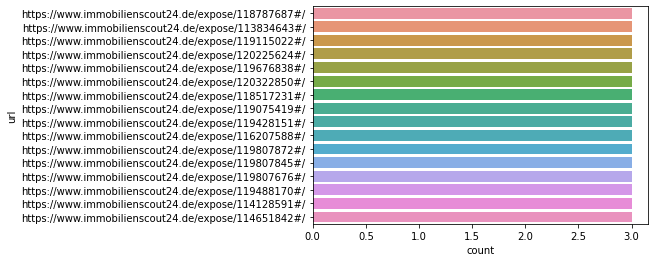

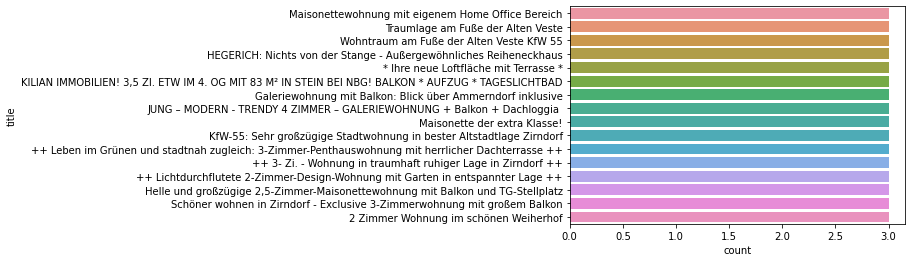

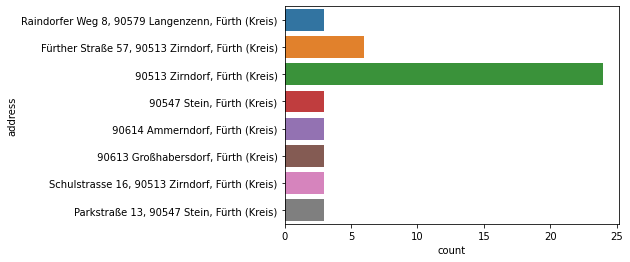

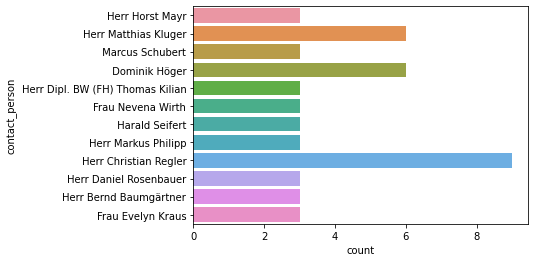

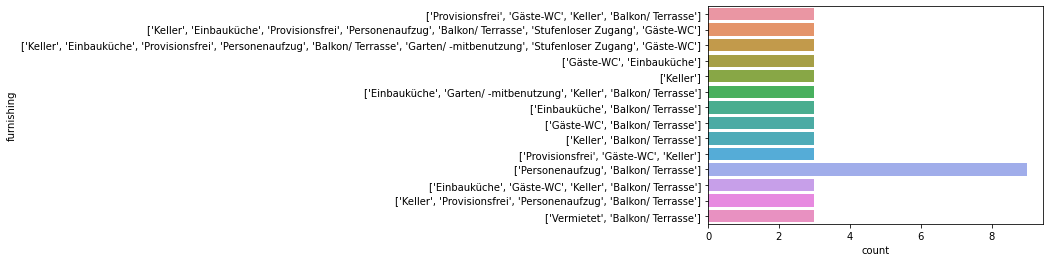

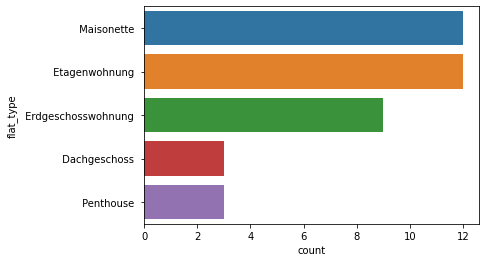

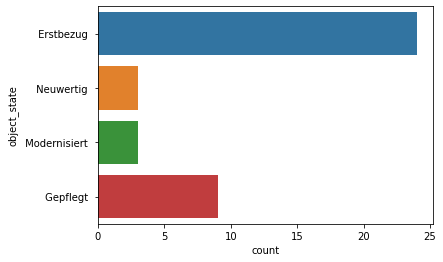

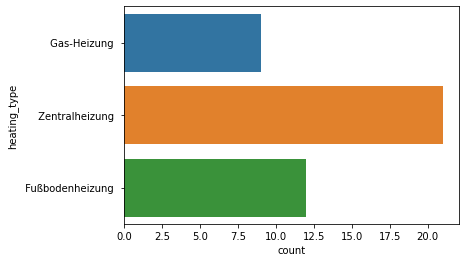

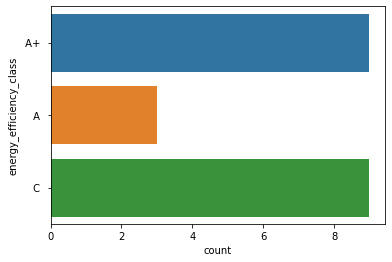

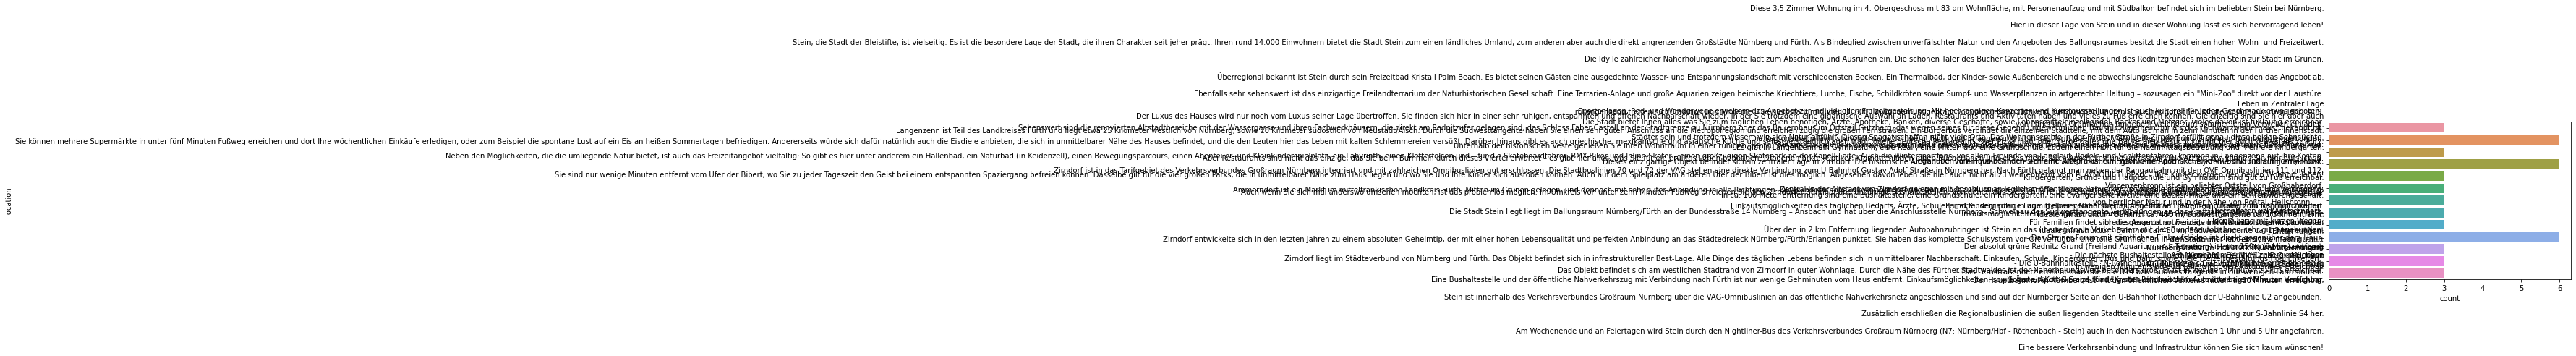

In [16]:
# TODO fix usage of list
# TODO data needs to be fixed
for features in df_base.dtypes[df_base.dtypes == 'object'].index:
    sns.countplot(y=features, data=df_base)
    plt.show()

## Data argmentation
Goal is to calculate the yearly ROI

In [17]:
df_finance = df_base[['url','price_purchase', 'living_area_m2', 'commission_buyer_rate']]
df_finance['price_per_m2'] = df_finance['price_purchase'] / df_finance['living_area_m2']
df_finance['notary_costs'] = notary_percentage * df_finance['price_purchase']

df_finance['land_registry_tax'] = land_registry_tax_percentage * df_finance['price_purchase']
df_finance['real_estate_transfer_tax'] = transfer_tax_percentage * df_finance['price_purchase']
df_finance['commission'] = df_finance['price_purchase'] * df_finance['commission_buyer_rate'] * 0.01 # TODO fix while parsing from scraper already
df_finance['total_buying_price'] = df_finance['price_purchase'] + df_finance['notary_costs'] + df_finance['land_registry_tax'] + df_finance['real_estate_transfer_tax'] + df_finance['commission']
df_finance['equity'] = equity_percentage * df_finance['total_buying_price']
df_finance['debt'] = df_finance['total_buying_price'] - df_finance['equity']
df_finance['interest_rate_monthly'] = interest_rate * df_finance['debt'] / 12
df_finance['mortgage_payment_yearly'] = mortgage_payment_rate * df_finance['debt']
df_finance['mortgage_payment_monthly'] = df_finance['mortgage_payment_yearly'] / 12
df_finance['monthly_rent'] = rent_price_index * df_finance['living_area_m2']
df_finance['additional_costs'] = additional_costs_rate_per_m2 * df_finance['living_area_m2']
df_finance['cashflow'] = df_finance['monthly_rent'] - df_finance['interest_rate_monthly'] - df_finance['mortgage_payment_monthly'] - df_finance['additional_costs']
df_finance['ROI'] = (df_finance['cashflow'] * 12) / df_finance['equity'] 





In [18]:
df_finance.sort_values(by=['ROI'], ascending=False)

,url,price_purchase,living_area_m2,commission_buyer_rate,price_per_m2,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment_yearly,mortgage_payment_monthly,monthly_rent,additional_costs,cashflow,ROI
4,https://www.immobilienscout24.de/expose/119676838#/,335000,132.00,4.00,2537.878788,5025.000,1675.000,16750.00,13400.0,371850.00,74370.000,297480.000,247.900000,5949.60000,495.800000,1188.00,118.800,325.50000,0.052521
36,https://www.immobilienscout24.de/expose/119676838#/,335000,132.00,4.00,2537.878788,5025.000,1675.000,16750.00,13400.0,371850.00,74370.000,297480.000,247.900000,5949.60000,495.800000,1188.00,118.800,325.50000,0.052521
20,https://www.immobilienscout24.de/expose/119676838#/,335000,132.00,4.00,2537.878788,5025.000,1675.000,16750.00,13400.0,371850.00,74370.000,297480.000,247.900000,5949.60000,495.800000,1188.00,118.800,325.50000,0.052521
38,https://www.immobilienscout24.de/expose/118517231#/,369000,130.00,4.64,2838.461538,5535.000,1845.000,18450.00,17121.6,411951.60,82390.320,329561.280,274.634400,6591.22560,549.268800,1170.00,117.000,229.09680,0.033368
6,https://www.immobilienscout24.de/expose/118517231#/,369000,130.00,4.64,2838.461538,5535.000,1845.000,18450.00,17121.6,411951.60,82390.320,329561.280,274.634400,6591.22560,549.268800,1170.00,117.000,229.09680,0.033368
22,https://www.immobilienscout24.de/expose/118517231#/,369000,130.00,4.64,2838.461538,5535.000,1845.000,18450.00,17121.6,411951.60,82390.320,329561.280,274.634400,6591.22560,549.268800,1170.00,117.000,229.09680,0.033368
24,https://www.immobilienscout24.de/expose/119428151#/,348000,120.00,4.00,2900.000000,5220.000,1740.000,17400.00,13920.0,386280.00,77256.000,309024.000,257.520000,6180.48000,515.040000,1080.00,108.000,199.44000,0.030979
40,https://www.immobilienscout24.de/expose/119428151#/,348000,120.00,4.00,2900.000000,5220.000,1740.000,17400.00,13920.0,386280.00,77256.000,309024.000,257.520000,6180.48000,515.040000,1080.00,108.000,199.44000,0.030979
8,https://www.immobilienscout24.de/expose/119428151#/,348000,120.00,4.00,2900.000000,5220.000,1740.000,17400.00,13920.0,386280.00,77256.000,309024.000,257.520000,6180.48000,515.040000,1080.00,108.000,199.44000,0.030979
5,https://www.immobilienscout24.de/expose/120322850#/,239000,83.00,4.99,2879.518072,3585.000,1195.000,11950.00,11926.1,267656.10,53531.220,214124.880,178.437400,4282.49760,356.874800,747.00,74.700,136.98780,0.030708


In [19]:
df_finance[(df_finance['cashflow'] > 0) ].sort_values(by=['ROI'], ascending=False)

,url,price_purchase,living_area_m2,commission_buyer_rate,price_per_m2,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment_yearly,mortgage_payment_monthly,monthly_rent,additional_costs,cashflow,ROI
4,https://www.immobilienscout24.de/expose/119676838#/,335000,132.00,4.00,2537.878788,5025.0,1675.0,16750.0,13400.0,371850.0,74370.00,297480.00,247.900000,5949.6000,495.800000,1188.00,118.800,325.5000,0.052521
20,https://www.immobilienscout24.de/expose/119676838#/,335000,132.00,4.00,2537.878788,5025.0,1675.0,16750.0,13400.0,371850.0,74370.00,297480.00,247.900000,5949.6000,495.800000,1188.00,118.800,325.5000,0.052521
36,https://www.immobilienscout24.de/expose/119676838#/,335000,132.00,4.00,2537.878788,5025.0,1675.0,16750.0,13400.0,371850.0,74370.00,297480.00,247.900000,5949.6000,495.800000,1188.00,118.800,325.5000,0.052521
6,https://www.immobilienscout24.de/expose/118517231#/,369000,130.00,4.64,2838.461538,5535.0,1845.0,18450.0,17121.6,411951.6,82390.32,329561.28,274.634400,6591.2256,549.268800,1170.00,117.000,229.0968,0.033368
38,https://www.immobilienscout24.de/expose/118517231#/,369000,130.00,4.64,2838.461538,5535.0,1845.0,18450.0,17121.6,411951.6,82390.32,329561.28,274.634400,6591.2256,549.268800,1170.00,117.000,229.0968,0.033368
22,https://www.immobilienscout24.de/expose/118517231#/,369000,130.00,4.64,2838.461538,5535.0,1845.0,18450.0,17121.6,411951.6,82390.32,329561.28,274.634400,6591.2256,549.268800,1170.00,117.000,229.0968,0.033368
40,https://www.immobilienscout24.de/expose/119428151#/,348000,120.00,4.00,2900.000000,5220.0,1740.0,17400.0,13920.0,386280.0,77256.00,309024.00,257.520000,6180.4800,515.040000,1080.00,108.000,199.4400,0.030979
8,https://www.immobilienscout24.de/expose/119428151#/,348000,120.00,4.00,2900.000000,5220.0,1740.0,17400.0,13920.0,386280.0,77256.00,309024.00,257.520000,6180.4800,515.040000,1080.00,108.000,199.4400,0.030979
24,https://www.immobilienscout24.de/expose/119428151#/,348000,120.00,4.00,2900.000000,5220.0,1740.0,17400.0,13920.0,386280.0,77256.00,309024.00,257.520000,6180.4800,515.040000,1080.00,108.000,199.4400,0.030979
37,https://www.immobilienscout24.de/expose/120322850#/,239000,83.00,4.99,2879.518072,3585.0,1195.0,11950.0,11926.1,267656.1,53531.22,214124.88,178.437400,4282.4976,356.874800,747.00,74.700,136.9878,0.030708


In [20]:
df_finance[(df_finance['cashflow'] > 0) & (df_finance['equity'] <= 25000) ].sort_values(by=['ROI'], ascending=False)

,url,price_purchase,living_area_m2,commission_buyer_rate,price_per_m2,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment_yearly,mortgage_payment_monthly,monthly_rent,additional_costs,cashflow,ROI
